In [1]:
from dask import dataframe as dd

In [156]:
dtypes = { 'session_id': 'uint64',
    'index': 'uint16',
    'elapsed_time': 'uint32',
    'event_name': 'object',
    'name': 'object',
    'level': 'uint8', 
    'page': 'float16',
    'room_coor_x': 'float64',
    'room_coor_y': 'float64',
    'screen_coor_x': 'float64',
    'screen_coor_y': 'float64',
    'hover_duration':'float64',
    'text': 'object',
    'fqid': 'object',
    'room_fqid': 'object',
    'text_fqid': 'object',
    'fullscreen':'object', 
    'hq':'object', 
    'music': 'object', 
    'level_group': 'object',
}

df_train = dd.read_csv("./train.csv", dtype=dtypes)
frame = df_train.compute()

In [6]:
df_train_labels = dd.read_csv("./train_labels.csv")
frame_labels = df_train_labels.compute()

In [9]:
frame_labels

,session_id,correct
0,20090312431273200_q1,1
1,20090312433251036_q1,0
2,20090314121766812_q1,1
3,20090314363702160_q1,1
4,20090314441803444_q1,1
...,...,...
212017,22100215342220508_q18,1
212018,22100215460321130_q18,1
212019,22100217104993650_q18,1
212020,22100219442786200_q18,1


In [12]:
frame_labels['question'] = frame_labels['session_id'].apply(lambda x: x.split('_q')[1])
frame_labels

,session_id,correct,question
0,20090312431273200_q1,1,1
1,20090312433251036_q1,0,1
2,20090314121766812_q1,1,1
3,20090314363702160_q1,1,1
4,20090314441803444_q1,1,1
...,...,...,...
212017,22100215342220508_q18,1,18
212018,22100215460321130_q18,1,18
212019,22100217104993650_q18,1,18
212020,22100219442786200_q18,1,18


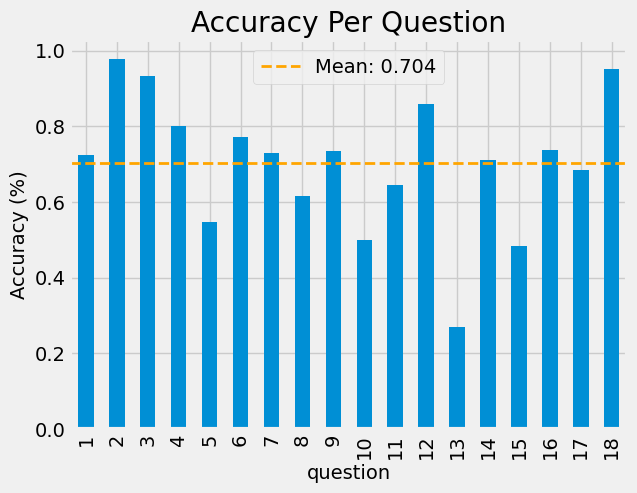

In [232]:
accuracy_table = frame_labels[frame_labels['correct']==1].groupby('question', sort=False).count()
accuracy_table['session_id'] = accuracy_table['correct'] / frame_labels.groupby('question', sort=False).count()['correct']
accuracy_table = accuracy_table.rename(columns={'session_id': 'accuracy', 'correct':'num_correct'})
ac_plt = accuracy_table['accuracy'].plot(kind='bar', title='Accuracy Per Question', ylabel='Accuracy (%)')

mean = accuracy_table['accuracy'].mean()
# ac_plt = ac_plt.ylabel('Accuracy (%)')
ac_plt.axhline(mean, color='orange', ls='--', lw=2)
ac_plt.legend([f'Mean: {mean:.3f}'])

In [73]:
import matplotlib.pyplot as plt
import numpy as np

In [237]:
def heatmap_clicks(column, value):
    x = frame.loc[frame[column]==value]['room_coor_x'].values
    y = frame.loc[frame[column]==value]['room_coor_y'].values
    x = x[~np.isnan(x)]
    y = y[~np.isnan(y)]
    plt.hist2d(x,y, bins=[np.arange(np.min(x),np.max(x),5),np.arange(np.min(y),np.max(y),5)])
    plt.title(f'Heatmap of clicks for {column}={value}')
    plt.show()

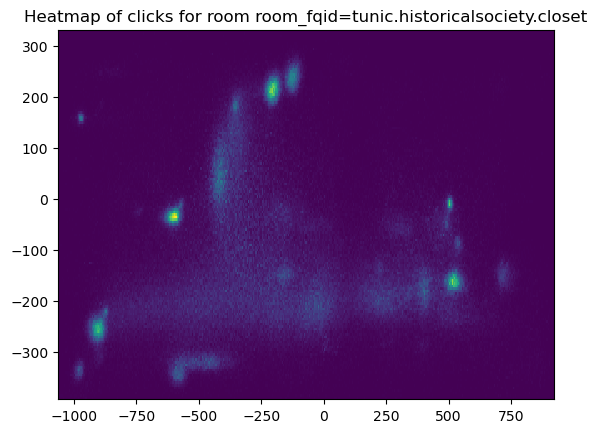

In [113]:
heatmap_clicks('room_fqid','tunic.historicalsociety.closet')

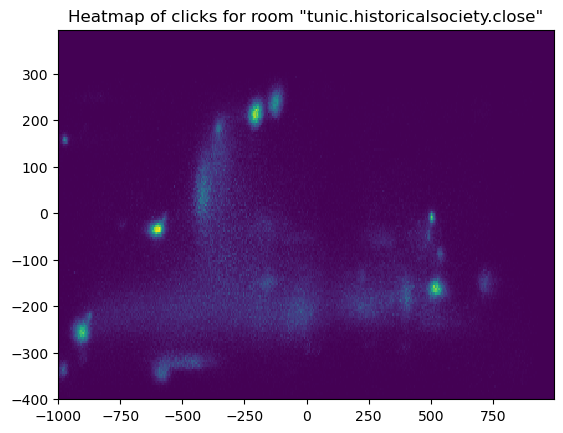

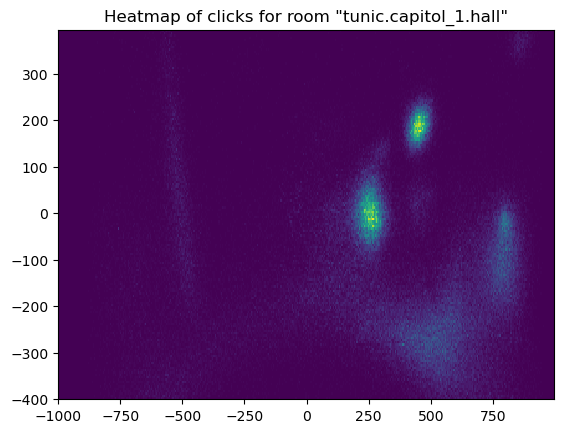

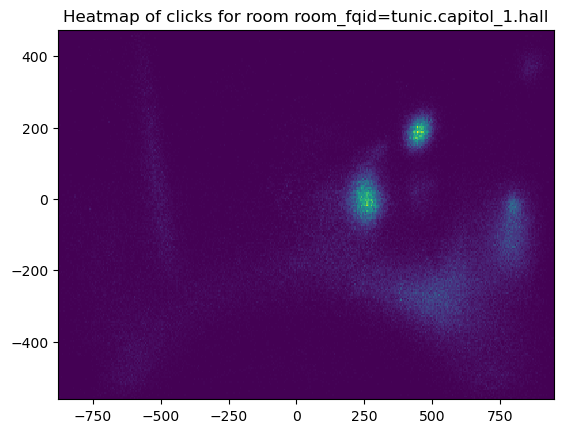

In [114]:
x = frame.loc[frame['room_fqid']=='tunic.capitol_1.hall']['room_coor_x'].values
y = frame.loc[frame['room_fqid']=='tunic.capitol_1.hall']['room_coor_y'].values
plt.hist2d(x,y, bins=[np.arange(-1000,1000,5),np.arange(-400,400,5)])
plt.title('Heatmap of clicks for room "tunic.capitol_1.hall"')
plt.show()
heatmap_clicks('room_fqid', 'tunic.capitol_1.hall')

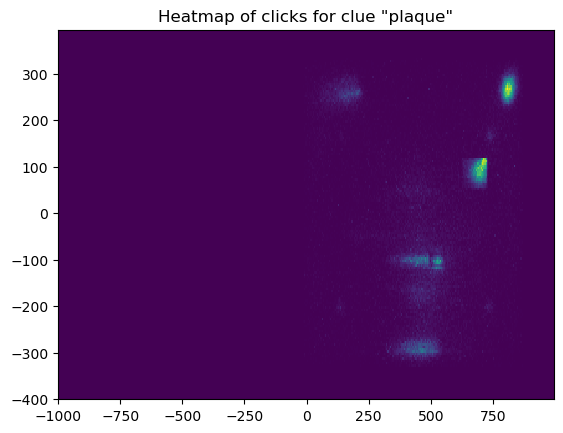

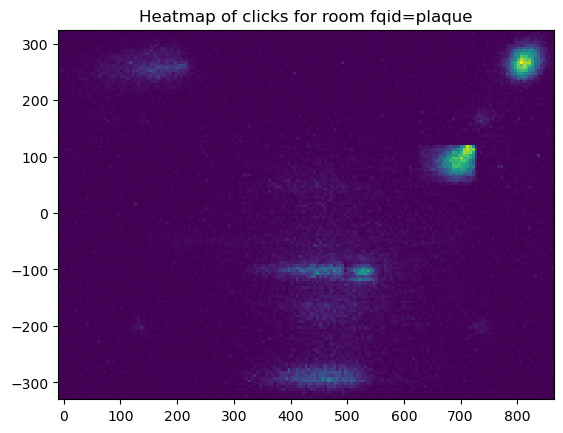

In [115]:
x = frame.loc[frame['fqid']=='plaque']['room_coor_x'].values
y = frame.loc[frame['fqid']=='plaque']['room_coor_y'].values
plt.hist2d(x,y, bins=[np.arange(-1000,1000,5),np.arange(-400,400,5)])
plt.title('Heatmap of clicks for clue "plaque"')
plt.show()
heatmap_clicks('fqid','plaque')

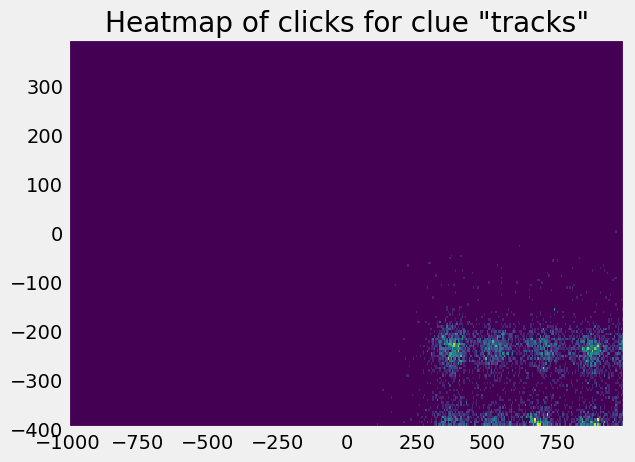

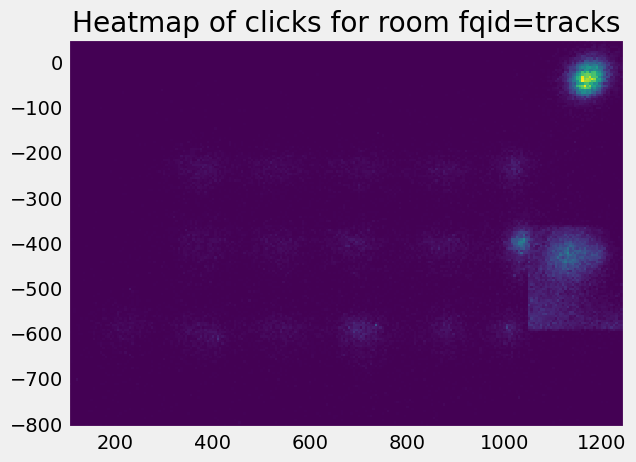

In [230]:
x = frame.loc[frame['fqid']=='tracks']['room_coor_x'].values
y = frame.loc[frame['fqid']=='tracks']['room_coor_y'].values
plt.hist2d(x,y, bins=[np.arange(-1000,1000,5),np.arange(-400,400,5)])
plt.title('Heatmap of clicks for clue "tracks"')
plt.show()
heatmap_clicks('fqid', 'tracks')

In [161]:

frame['previous_session_id'] = frame['session_id'].shift()
frame['is_from_previous'] = frame['session_id'] == frame['previous_session_id']
frame['is_from_previous'] = frame['is_from_previous'].map({False:np.NaN, True:1})
frame['time_from_previous'] = frame['time_from_previous'] * frame['is_from_previous']

In [162]:
frame['previous_elapsed_time'] = frame['elapsed_time'].shift(fill_value=0.0)
frame['time_from_previous'] = frame['elapsed_time'] - frame['previous_elapsed_time']

In [276]:
frame2 = frame[frame['room_fqid']=='tunic.library.frontdesk']
ecology_desk_time = frame2.groupby('session_id').sum('time_from_previous')
ecology_desk_time = ecology_desk_time.reset_index()[['session_id', 'time_from_previous']]
ecology_desk_time

,session_id,time_from_previous
0,20090312431273200,4295055891
1,20090312433251036,8590583180
2,20090314121766812,12885007051
3,20090314363702160,4295044875
4,20090314441803444,94122
...,...,...
11774,22100215342220508,151381
11775,22100215460321130,4295099096
11776,22100217104993650,4295046866
11777,22100219442786200,4295057069


In [180]:


frame_labels['session'] = frame_labels['session_id'].apply(lambda x: x.split('_q')[0]).astype('int64')
# frame_labels['session'] = frame_labels['session'].apply(dd.to_numeric).calculate()

In [277]:
sesh = frame_labels[frame_labels['question']=='13'].set_index('session').join(ecology_desk_time.set_index('session_id')).reset_index()[['session', 'correct','time_from_previous']]

In [278]:
sesh

,session,correct,time_from_previous
0,20090312431273200,0,4295055891
1,20090312433251036,0,8590583180
2,20090314121766812,0,12885007051
3,20090314363702160,0,4295044875
4,20090314441803444,0,94122
...,...,...,...
11774,22100215342220508,0,151381
11775,22100215460321130,0,4295099096
11776,22100217104993650,1,4295046866
11777,22100219442786200,0,4295057069


C:\Users\BROWDERKD20\AppData\Local\Temp\ipykernel_20256\1368634064.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  m1 = sesh[sesh['time_from_previous'] < 1000000][sesh['correct']==0]['time_from_previous'].median()
C:\Users\BROWDERKD20\AppData\Local\Temp\ipykernel_20256\1368634064.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  s1 = sesh[sesh['time_from_previous'] < 1000000][sesh['correct']==0]['time_from_previous'].std()
C:\Users\BROWDERKD20\AppData\Local\Temp\ipykernel_20256\1368634064.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  m2 = sesh[sesh['time_from_previous'] < 1000000][sesh['correct']==1]['time_from_previous'].median()
C:\Users\BROWDERKD20\AppData\Local\Temp\ipykernel_20256\1368634064.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  s2 = sesh[sesh['time_from_previous'] < 1000000][sesh['correct']==1]['time_from_previous'].std()
C:\Use

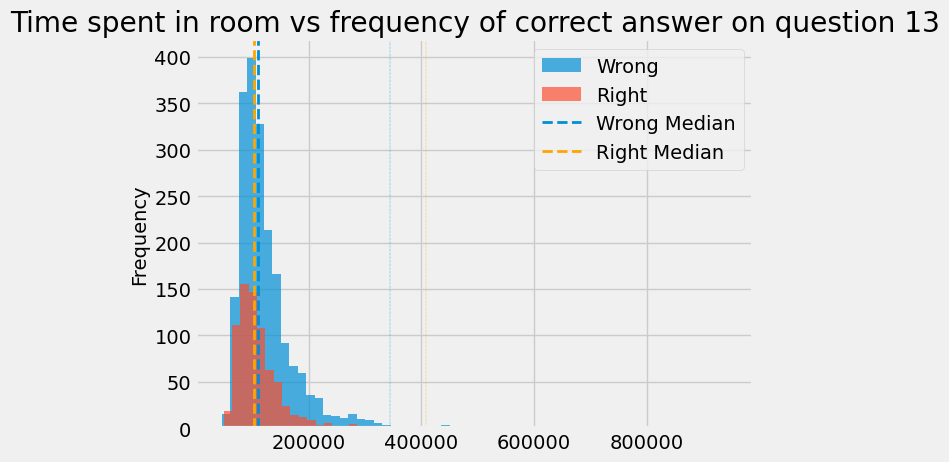

In [280]:
plt.style.use('fivethirtyeight')
m1 = sesh[sesh['time_from_previous'] < 1000000][sesh['correct']==0]['time_from_previous'].median()
s1 = sesh[sesh['time_from_previous'] < 1000000][sesh['correct']==0]['time_from_previous'].std()
m2 = sesh[sesh['time_from_previous'] < 1000000][sesh['correct']==1]['time_from_previous'].median()
s2 = sesh[sesh['time_from_previous'] < 1000000][sesh['correct']==1]['time_from_previous'].std()
s = sesh[sesh['time_from_previous'] < 1000000][sesh['correct']==0]['time_from_previous'].plot(kind='hist',bins=60, alpha=0.7,legend=True)
s = sesh[sesh['time_from_previous'] < 1000000][sesh['correct']==1]['time_from_previous'].plot(kind='hist',bins=60, alpha=0.7,legend=True, title="Time spent in room vs frequency of correct answer on question 13")
s.axvline(m1, ls='--', lw=2)
s.axvline(m2, color='orange', ls='--', lw=2)
s.axvline(m1+ 3* s1, ls='-.', lw=.25)


s.axvline(m2+ 3* s2, color='orange', ls='-.', lw=.25)
s.legend(["Wrong", "Right","Wrong Median", "Right Median"])

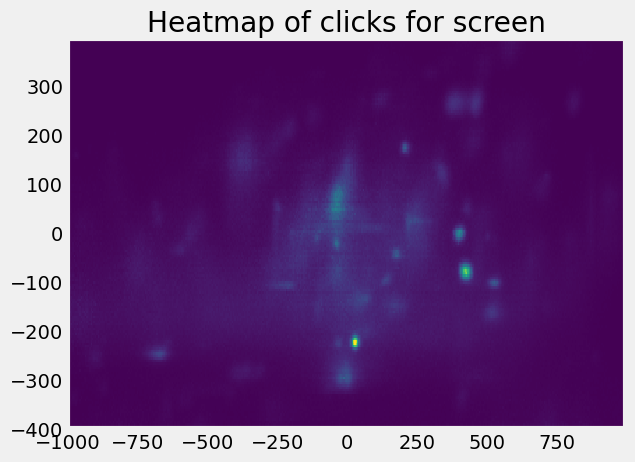

In [243]:
x = frame['room_coor_x'].values
y = frame['room_coor_y'].values
plt.hist2d(x,y, bins=[np.arange(-1000,1000,5),np.arange(-400,400,5)])
plt.title('Heatmap of clicks for screen')
plt.show()

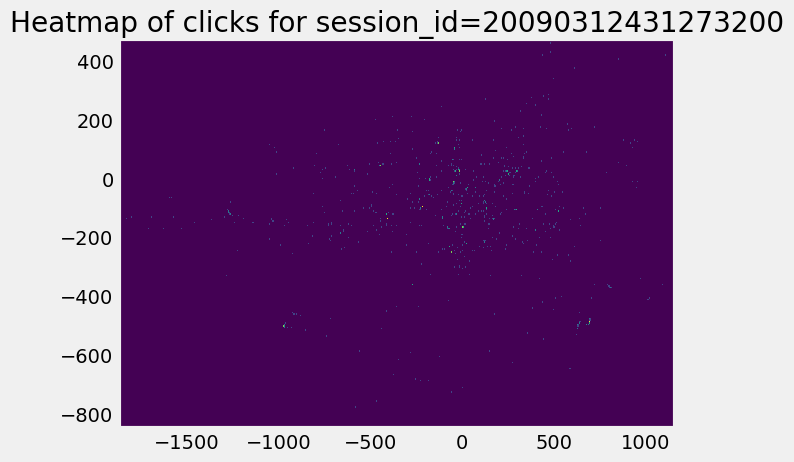

In [238]:
heatmap_clicks('session_id', 20090312431273200)